# This notebook calculates AUstralia APW based on .rot files from global plate reconstructions

In [1]:
import os, sys
import pmagpy.ipmag as ipmag
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import pygplates
from bayesian_pep import *
%config InlineBackend.figure_format = 'retina'

In [2]:
## Create a function that reproduces the APW path
## of Mueller et al 1993, for Australia relative
## to a hotspot reference frame.
class apw_path_function(object):
    def __init__(self):
        # enumerate euler poles, rotation angles, and changepoints for the Cenozoic
        self.angles = np.array([7.27, 13.23-7.27, 22.47-13.23, 26.0-22.47, 27.67-26.0, 27.86-27.67, 28.72-27.86])
        self.changepoints = np.array([10.4, 20.5, 35.5, 42.7, 50.3, 58.6, 68.5])
        
        self.e1 = EulerPole( 40.6+180., -23.7, self.angles[0]/self.changepoints[0]) 
        self.e2 = EulerPole( 31.4+180., -27.1, self.angles[1]/(self.changepoints[1]-self.changepoints[0])) 
        self.e3 = EulerPole( 30.1+180., -22.7, self.angles[2]/(self.changepoints[2]-self.changepoints[1])) 
        self.e4 = EulerPole( 27.8+180., -24.0, self.angles[3]/(self.changepoints[3]-self.changepoints[2])) 
        self.e5 = EulerPole( 25.9+180., -23.3, self.angles[4]/(self.changepoints[4]-self.changepoints[3])) 
        self.e6 = EulerPole( 26.2+180., -23.0, self.angles[5]/(self.changepoints[5]-self.changepoints[4])) 
        self.e7 = EulerPole( 26.8+180., -18.3, self.angles[6]/(self.changepoints[6]-self.changepoints[5])) 
        self.euler_poles = [self.e1,self.e2,self.e3,self.e4,self.e5,self.e6,self.e7]

    def __call__(self,age):
        pole = Pole( 0., -90., 1.)
        current_age=0
        for euler, angle, change in zip(self.euler_poles, self.angles, self.changepoints):
            if age > change:
                pole.rotate( euler, -angle )
                current_age = change
            else:
                pole.rotate( euler, -euler.rate*(age-current_age))
                break
        return pole.longitude, pole.latitude

    def speed(self, age):
        assert(age < self.changepoints[-1] and age >= 0)
        for i,c in enumerate(self.changepoints):
            if c > age:
                return self.euler_poles[i].speed_at_point(uluru)

## Get APW from Muller et al., 2016

- Müller, R. D., Seton, M., Zahirovic, S., Williams, S. E., Matthews, K. J., Wright, N. M., ... & Cannon, J. (2016). Ocean basin evolution and global-scale plate reorganization events since Pangea breakup. Annual Review of Earth and Planetary Sciences, 44, 107-138. DOI:10.1146/annurev-earth-060115-012211


(19.290276414584273, 38.41308081432312, -30.692788089757702)


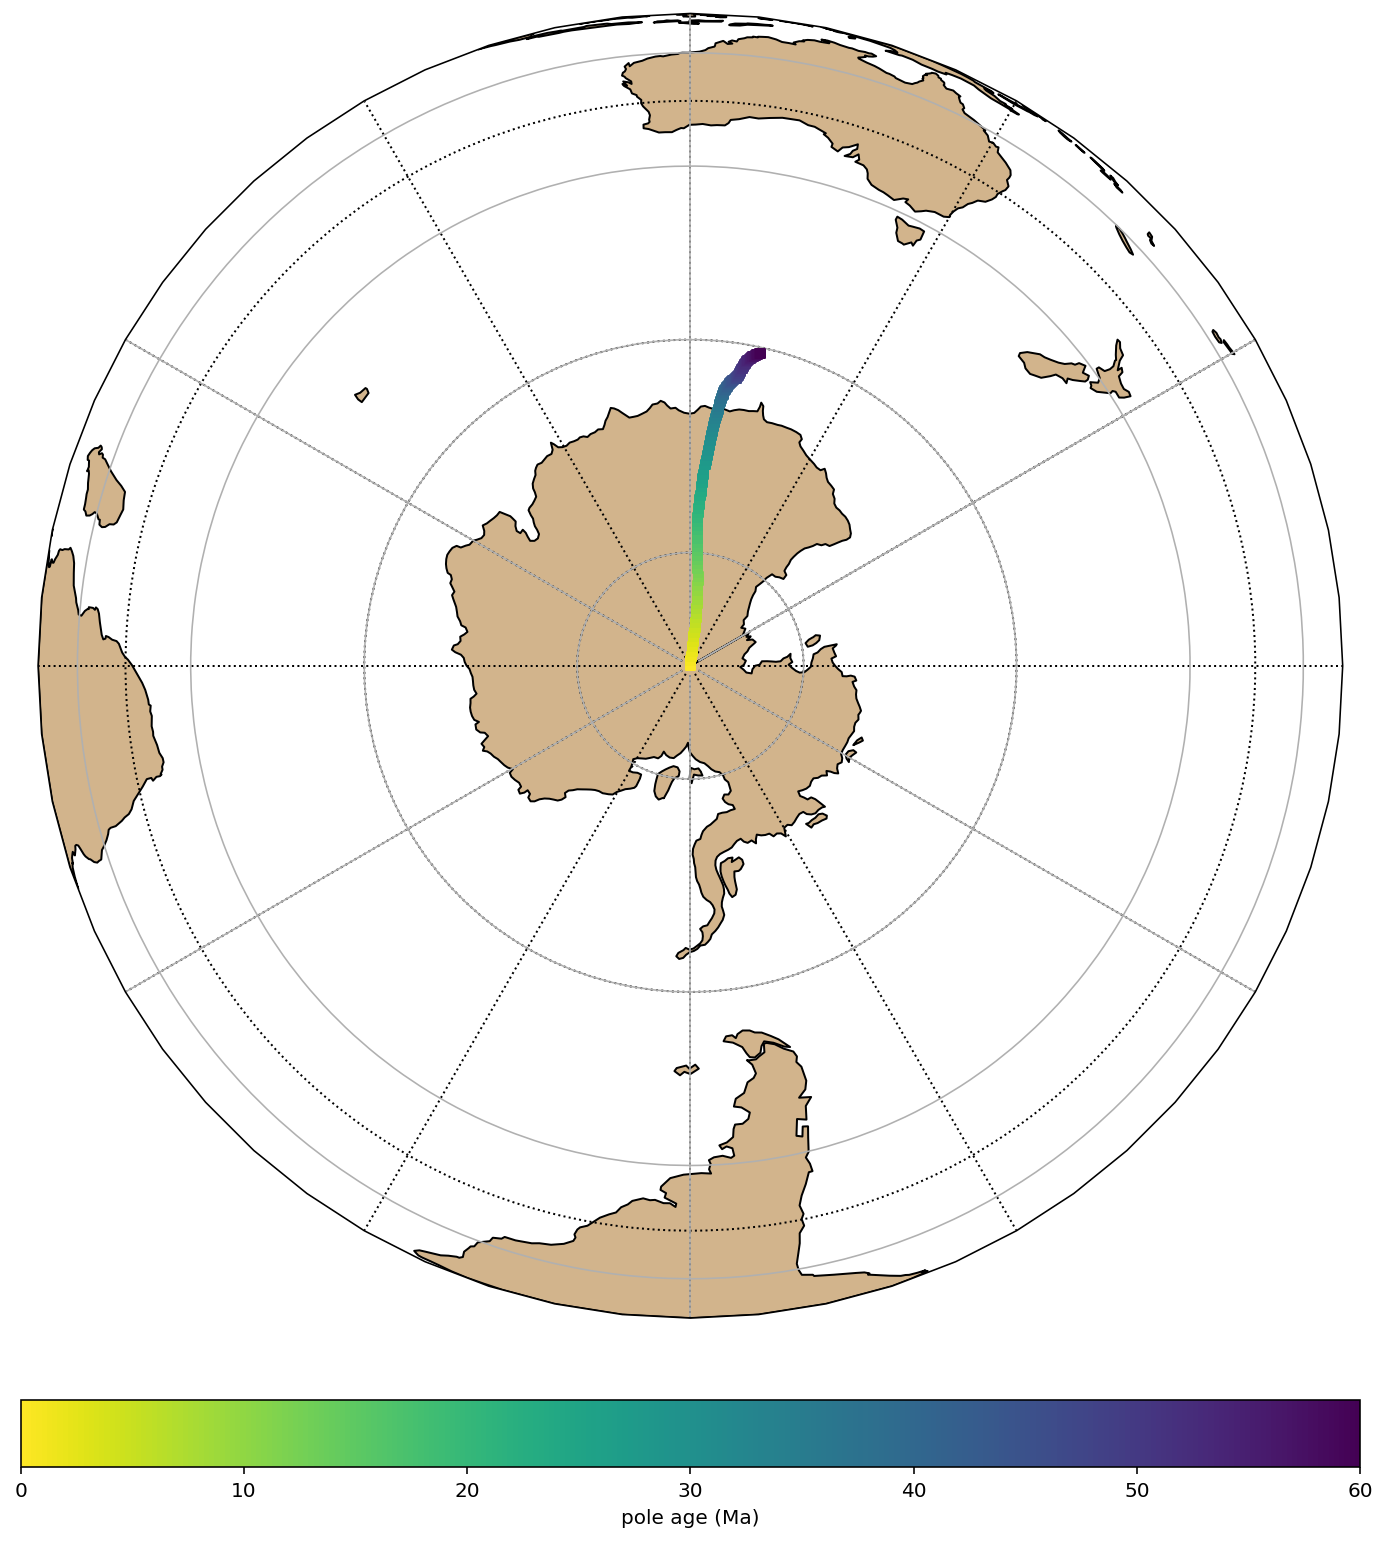

In [4]:
input_rotation_filename = 'data/Australia_poles/Muller2016a_Global_EarthByte_230-0Ma_GK07_AREPS.rot'
rotation_model = pygplates.RotationModel(input_rotation_filename)
fixed_plate = 1 # Indo-atlantic hotspot frame
australia = 801

Muller2016a_apw = apw_path_function()

times = np.linspace( 0., 60., 100)
lats = np.empty_like(times)
lons = np.empty_like(times)
pole = PlateCentroid( 0., -90. )

for i,t in enumerate(times):
    start_time = 0. if t==0. else times[i-1]
    rotation = rotation_model.get_rotation( t, australia, start_time, fixed_plate)
    lat, lon, angle = rotation.get_lat_lon_euler_pole_and_angle_degrees()
    euler_pole = EulerPole( lon, lat, 1.) # Don't care about the rate here
    pole.rotate( euler_pole, -angle)
    lats[i] = pole.latitude
    lons[i] = pole.longitude

average_rotation = rotation_model.get_rotation(times[-1], australia, 0.0, fixed_plate)
print(average_rotation.get_lat_lon_euler_pole_and_angle_degrees())

mlats = [Muller2016a_apw(t)[1] for t in times]
mlons = [Muller2016a_apw(t)[0] for t in times]

# plt.figure(figsize=(15,15))
ax = ipmag.make_orthographic_map(120, -90, figsize=(15,15))
# ax.plot(lons,lats, transform=ccrs.PlateCarree(), lw=2)
# ax.plot(mlons, mlats, transform=ccrs.PlateCarree(), lw=2)

ipmag.plot_poles_colorbar(ax,lons,
                          lats,
                          np.zeros(len(lats)),
                          times,
                          0,60,colormap='viridis_r',
                          markersize=20,marker='s',edgecolor=None)

ax.set_global()
ax.gridlines()
lon_shift=0.
# plot.plot_continent(ax, 'australia', rotation_pole=Pole(0., 90., 1.0), angle=-lon_shift, color='k')
# plot.plot_continent(ax, 'antarctica', rotation_pole=Pole(0., 90., 1.0), angle=-lon_shift, color='k')

plt.show()

np.savetxt('./data/Australia_poles/australia_apw_muller_2016.txt', np.array([times, lons, lats]).T )

